- [Decoder for Text Generation](https://machinelearningmastery.com/beam-search-decoder-natural-language-processing/)
- [Beam search using heap](https://geekyisawesome.blogspot.com/2016/10/using-beam-search-to-generate-most.html)
- [BeamSearch](https://yashk2810.github.io/Image-Captioning-using-InceptionV3-and-Beam-Search/)

In [1]:
import os
import json
from queue import PriorityQueue

import numpy as np

import imageio
from skimage.transform import resize

import torch
import torch.nn.functional as F
import torchvision.transforms as transforms

import operator
import matplotlib.pyplot as plt

# MobileNetV2

In [2]:
"""
Creates a MobileNetV2 model as defined in the paper: M. Sandler, 
A. Howard, M. Zhu, A. Zhmoginov, L.-C. Chen. "MobileNetV2: Inverted 
Residuals and Linear Bottlenecks.", arXiv:1801.04381, 2018."

Code reference: https://github.com/tonylins/pytorch-mobilenet-v2
ImageNet pretrained weights: https://drive.google.com/file/d/1jlto6HRVD3ipNkAl1lNhDbkBp7HylaqR
"""
import math
import torch
import torch.nn as nn



def conv_bn(inp, oup, stride):
    return nn.Sequential(
        nn.Conv2d(inp, oup, 3, stride, 1, bias=False),
        nn.BatchNorm2d(oup),
        nn.ReLU6(inplace=True)
    )


def conv_1x1_bn(inp, oup):
    return nn.Sequential(
        nn.Conv2d(inp, oup, 1, 1, 0, bias=False),
        nn.BatchNorm2d(oup),
        nn.ReLU6(inplace=True)
    )


class InvertedResidual(nn.Module):
    def __init__(self, inp, oup, stride, expand_ratio):
        super(InvertedResidual, self).__init__()
        self.stride = stride
        assert stride in [1, 2]

        hidden_dim = round(inp * expand_ratio)
        self.use_res_connect = self.stride == 1 and inp == oup

        if expand_ratio == 1:
            self.conv = nn.Sequential(
                # dw
                nn.Conv2d(hidden_dim, hidden_dim, 3, stride, 1, groups=hidden_dim, bias=False),
                nn.BatchNorm2d(hidden_dim),
                nn.ReLU6(inplace=True),
                # pw-linear
                nn.Conv2d(hidden_dim, oup, 1, 1, 0, bias=False),
                nn.BatchNorm2d(oup),
            )
        else:
            self.conv = nn.Sequential(
                # pw
                nn.Conv2d(inp, hidden_dim, 1, 1, 0, bias=False),
                nn.BatchNorm2d(hidden_dim),
                nn.ReLU6(inplace=True),
                # dw
                nn.Conv2d(hidden_dim, hidden_dim, 3, stride, 1, groups=hidden_dim, bias=False),
                nn.BatchNorm2d(hidden_dim),
                nn.ReLU6(inplace=True),
                # pw-linear
                nn.Conv2d(hidden_dim, oup, 1, 1, 0, bias=False),
                nn.BatchNorm2d(oup),
            )

    def forward(self, x):
        if self.use_res_connect:
            return x + self.conv(x)
        else:
            return self.conv(x)


class MobileNetV2(nn.Module):
    def __init__(self, n_class=1000, input_size=224, width_mult=1.):
        super(MobileNetV2, self).__init__()
        block = InvertedResidual
        input_channel = 32
        last_channel = 1280
        interverted_residual_setting = [
            # t, c, n, s
            [1, 16, 1, 1],
            [6, 24, 2, 2],
            [6, 32, 3, 2],
            [6, 64, 4, 2],
            [6, 96, 3, 1],
            [6, 160, 3, 2],
            [6, 320, 1, 1],
        ]

        # building first layer
        assert input_size % 32 == 0
        input_channel = int(input_channel * width_mult)
        self.last_channel = int(last_channel * width_mult) if width_mult > 1.0 else last_channel
        self.features = [conv_bn(3, input_channel, 2)]
        # building inverted residual blocks
        for t, c, n, s in interverted_residual_setting:
            output_channel = int(c * width_mult)
            for i in range(n):
                if i == 0:
                    self.features.append(block(input_channel, output_channel, s, expand_ratio=t))
                else:
                    self.features.append(block(input_channel, output_channel, 1, expand_ratio=t))
                input_channel = output_channel
        # building last several layers
        self.features.append(conv_1x1_bn(input_channel, self.last_channel))
        # make it nn.Sequential
        self.features = nn.Sequential(*self.features)

        # building classifier
        self.classifier = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(self.last_channel, n_class),
        )

        self._initialize_weights()

    def forward(self, x):
        x = self.features(x)
        x = x.mean(3).mean(2)
        x = self.classifier(x)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
                if m.bias is not None:
                    m.bias.data.zero_()
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                n = m.weight.size(1)
                m.weight.data.normal_(0, 0.01)
                m.bias.data.zero_()
                
def MobileNet(pretrained=True, **kwargs):
    """
    Constructs a MobileNet V2 model.
    
    Parameters
    ----------
    pretrained: bool, use ImageNet pretrained model or not.
    n_class: int, 1000 classes in ImageNet data.
    weight_file: str, path to pretrained weights
    """
    weight_file = kwargs.pop('weight_file', '')
    model = MobileNetV2(**kwargs)
    if pretrained:
        state_dict = torch.load(weight_file)
        model.load_state_dict(state_dict)
    return model

# Encoder

In [3]:
class EncoderCNN(nn.Module):
    """
    Convolutional Neural Network (MobileNetV2) that encodes input image 
    into encoded feature representations.
    """
    def __init__(self, weight_file, feature_size=14, tune_layer=None, finetune=False):
        """
        Parameters
        ----------
        weight_file: str, path to MobileNetV2 pretrained weights.
        feature_size: int, encoded feature map size to be used.
        tune_layer: int, tune layers from this layer onwards. For
            MobileNetV2 select integer from 0 (early) to 18 (final)
        finetune: bool, fine tune layers
        """
        super(EncoderCNN, self).__init__()
        self.weight_file = weight_file
        self.feature_size = feature_size
        self.tune_layer = tune_layer
        self.finetune = finetune
        self.pretrained = False
        
        # MobileNetV2 pretrained on ImageNet
        cnn = MobileNet(pretrained=self.pretrained, weight_file=self.weight_file)
        
        # Remove classification layer
        modules = list(cnn.children())[:-1]
        self.cnn = nn.Sequential(*modules)
        
        # Resize feature maps to fixed size to allow input images of variable size
        self.adaptive_pool = nn.AdaptiveAvgPool2d((self.feature_size, self.feature_size))
        
        # Fine-tune
        self.fine_tune()
        
    def forward(self, images):
        """
        Parameters
        ----------
        images: PyTorch tensor, size: [M, 3, H, W]
        """
        features = self.cnn(images) # size: [M, 1280, H/32, W/32]
        features = self.adaptive_pool(features) # size: [M, 1280, fs, fs]
        features = features.permute(0, 2, 3, 1) # size: [M, fs, fs, 1280]
        return features
    
    def fine_tune(self):
        """
        Fine-tuning CNN.
        """
        # Disable gradient computation
        for param in self.cnn.parameters():
            param.requires_grad = False
            
        # Enable gradient computation for few layers
        for child in list(self.cnn.children())[0][self.tune_layer:]:
            for param in child.parameters():
                param.requires_grad = self.finetune

# Attention Mechanism

In [4]:
class AttentionMechanism(nn.Module):
    """
    Attention Mechanism.
    """
    def __init__(self, encoder_size, decoder_size, attention_size):
        """
        Parameters
        ----------
        encoder_size: int, number of channels in encoder CNN output feature
            map (for MobileNetV2 it is 1280)
        decoder_size: int, number of features in the hidden state, i.e. LSTM 
            output size
        attention_size: int, size of MLP used to compute attention scores
        """
        super(AttentionMechanism, self).__init__()
        self.encoder_size = encoder_size
        self.decoder_size = decoder_size
        self.attention_size = attention_size
        
        # Linear layer to transform encoded features to attention size
        self.encoder_attn = nn.Linear(in_features=self.encoder_size, 
                                      out_features=self.attention_size)
        
        # Linear layer to transform decoders (hidden state) output to attention size
        self.decoder_attn = nn.Linear(in_features=self.decoder_size, 
                                      out_features=self.attention_size)
        
        # ReLU non-linearity
        self.relu = nn.ReLU()
        
        # Linear layer to compute attention scores at time t for L locations
        self.fc_attn = nn.Linear(in_features=self.attention_size, out_features=1)
        
        # Softmax layer to compute attention weights
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, encoder_out, decoder_out):
        """
        Parameters
        ----------
        encoder_out: PyTorch tensor, size: [M, L, D] where, L is feature
            map locations, and D is channels of encoded CNN feature map.
        decoder_out: PyTorch tensor, size: [M, h], where h is hidden
            dimension of the previous step output from decoder
            
        NOTE: M is batch size. k is attention size (see comments)
        
        Returns
        -------
        attn_weighted_encoding: PyTorch tensor, size: [M, D], attention weighted 
            annotation vector
        alpha: PyTorch tensor, size: [M, L], attention weights 
        """
        enc_attn = self.encoder_attn(encoder_out)  # size: [M, L, k]
        dec_attn = self.decoder_attn(decoder_out)  # size: [M, k]
        
        enc_dec_sum = enc_attn + dec_attn.unsqueeze(1)  # size: [M, L, k]
        
        # Compute attention scores for L locations at time t (Paper eq: 4)
        attn_scores = self.fc_attn(self.relu(enc_dec_sum))  # size: [M, L]
        
        # Compute for each location the probability that location i is the right 
        # place to focus for generating next word (Paper eq: 5)
        alpha = self.softmax(attn_scores.squeeze(2))  # size: [M, L]
        
        # Compute attention weighted annotation vector (Paper eq: 6)
        attn_weighted_encoding = torch.sum(encoder_out * alpha.unsqueeze(2), dim=1) # size: [M, D]
        
        return attn_weighted_encoding, alpha

# Decoder

In [5]:
class DecoderAttentionRNN(nn.Module):
    """
    RNN (LSTM) decoder to decode encoded images and generate sequences.
    """
    def __init__(self, encoder_size, decoder_size, attention_size, embedding_size, vocab_size, dropout_prob=0.5):
        """
        encoder_size: int, number of channels in encoder CNN output feature
            map (for MobileNetV2 it is 1280)
        decoder_size: int, number of features in the hidden state, i.e. LSTM 
            output size
        attention_size: int, size of MLP used to compute attention scores
        embedding_size: int, size of embedding
        vocab_size: int, vocabulary size
        dropout: float, dropout probability
        """
        super(DecoderAttentionRNN, self).__init__()
        self.encoder_size = encoder_size
        self.decoder_size = decoder_size
        self.attention_size = attention_size
        self.embedding_size = embedding_size
        self.vocab_size = vocab_size
        self.dropout_prob = dropout_prob
        
        # Create attention mechanism
        self.attention = AttentionMechanism(self.encoder_size, self.decoder_size, self.attention_size)
        
        # Create embedding layer
        self.embedding = nn.Embedding(self.vocab_size, self.embedding_size)  # size: [V, E]
        
        # Create dropout module
        self.dropout = nn.Dropout(p=self.dropout_prob)
        
        # Create LSTM cell (uses for loop) for decoding
        self.rnn = nn.LSTMCell(input_size=self.embedding_size + self.encoder_size, 
                               hidden_size=self.decoder_size, bias=True)
        
        # MLPs for LSTM cell's initial states
        self.init_h = nn.Linear(self.encoder_size, self.decoder_size)
        self.init_c = nn.Linear(self.encoder_size, self.decoder_size)
        
        # MLP to compute beta (gating scalar, paper section 4.2.1)
        self.f_beta = nn.Linear(self.decoder_size, 1) # scalar
        
        # Sigmoid to compute beta
        self.sigmoid = nn.Sigmoid()
        
        # FC layer to compute scores over vocabulary
        self.fc = nn.Linear(self.decoder_size, self.vocab_size)
        
    def init_lstm_states(self, encoder_out):
        """
        Initialize LSTM's initial hidden and cell memory states based on encoded
        feature representation. NOTE: Encoded feature map locations mean is used.
        """
        # Compute mean of encoder output locations
        mean_encoder_out = torch.mean(encoder_out, dim=1)  # size: [M, L, D] -> [M, D]
        
        # Initialize LSTMs hidden state
        h0 = self.init_h(mean_encoder_out)  # size: [M, h]
        
        # Initialize LSTMs cell memory state
        c0 = self.init_c(mean_encoder_out)  # size: [M, h]
        
        return h0, c0
    
    def forward(self, encoder_out, encoded_captions, caption_lengths):
        """
        Parameters
        ----------
        encoder_out: PyTorch tensor, size: [M, fs, fs, D] where, fs is feature
            map size, and D is channels of encoded CNN feature map.
        encoded_captions: PyTorch long tensor
        caption_lengths: PyTorch tensor
        """
        batch_size = encoder_out.size(0)
        
        # Flatten encoded feature maps from size [M, fs, fs, D] to [M, L, D]
        encoder_out = encoder_out.view(batch_size, -1, self.encoder_size)
        num_locations = encoder_out.size(1)
        
        # Sort caption lengths in descending order
        caption_lengths, sorted_idx = torch.sort(caption_lengths.squeeze(1), dim=0, 
                                                 descending=True)
        
        # Compute decode lengths to decode. Sequence generation ends when <END> token
        # is generated. A typical caption is [<START>, ..., <END>, <PAD>, <PAD>], caption
        # lengths only considers [<START>, ..., <END>], so when <END> is generated there
        # is no need to decode further. Decode lengths = caption lengths - 1
        decode_lengths = (caption_lengths - 1).tolist()
        
        # Sort encoded feature maps and captions as per caption lengths. REASON: Since a 
        # batch contains different caption lengths (and decode lengths). At each time step 
        # up to max decode length T in a batch we need to apply attention mechanism to only 
        # those images in batch whose decode length is greater than current time step
        encoder_out = encoder_out[sorted_idx]
        encoded_captions = encoded_captions[sorted_idx]
        
        # Get embeddings for encoded captions
        embeddings = self.embedding(encoded_captions) # size: [M, T, E]
        
        # Initialize LSTM's states
        h, c = self.init_lstm_states(encoder_out) # sizes: [M, h], [M, h]
        
        # Compute max decode length
        T = int(max(decode_lengths))
        
        # Create placeholders to store predicted scores and alphas (alphas for doubly stochastic attention)
        pred_scores = torch.zeros(batch_size, T, self.vocab_size) # size: [M, T, V]
        alphas = torch.zeros(batch_size, T, num_locations) # size: [M, T, L]
        
        # Decoding step: (1) Compute attention weighted encoding and attention weights
        # using encoder output, and initial hidden state; (2) Generate a new encoded word
        for t in range(T):
            # Compute batch size at step t (At step t how many decoding lengths are greater than t)
            batch_size_t = sum([dl > t for dl in decode_lengths])
            
            # Encoder output and encoded captions are already sorted by caption lengths
            # in descending order. So based on the number of decoding lengths that are 
            # greater than current t, extract data from encoded output and initial hidden state
            # as input to attention mechanism. 
            attn_weighted_encoding, alpha = self.attention(encoder_out[:batch_size_t],
                                                           h[:batch_size_t])
                        
            # Compute gating scalar beta (paper section: 4.2.1)
            beta_t = self.sigmoid(self.f_beta(h[:batch_size_t])) # size: [M, 1]
                        
            # Multiply gating scalar beta to attention weighted encoding
            context_vector = beta_t * attn_weighted_encoding  # size: [M, D]
                        
            # Concatenate embeddings and context vector, size: [M, E] and [M, D] -> [M, E+D]
            concat_input = torch.cat([embeddings[:batch_size_t, t, :], context_vector], dim=1) # size: [M, E+D]
                        
            # LSTM input states from time step t-1
            previous_states = (h[:batch_size_t], c[:batch_size_t])
                        
            # Generate decoded word
            h, c = self.rnn(concat_input, previous_states)
            
            # Compute scores over vocabulary
            scores = self.fc(self.dropout(h)) # size: [M, V]
            
            # Populate placeholders for predicted scores and alphas
            pred_scores[:batch_size_t, t, :] = scores
            alphas[:batch_size_t, t, :] = alpha # alpha size: [M, L]
            
        return pred_scores, encoded_captions, decode_lengths, alphas, sorted_idx

# Config

In [6]:
class Config(object):
    def __init__(self):
        # Encoder parameters
        # ------------------
        self.weight_file = None
        
        # Decoder parameters
        # ------------------
        self.encoder_size = 1280 # 1280 for MobileNetV2
        self.decoder_size = 512  # LSTM output size (hidden state vector size)
        self.attention_size = 512  # Size of MLP used to compute attention scores
        self.embedding_size = 256  # Word embedding size
        self.dropout_prob = 0.5

        # Word to index mapping
        # ---------------------
        self.word2idx_file = './WORD2IDX_CROP_COCO.json'
        
        # Checkpoint
        # ----------
        self.checkpoint_path = './MobileNetV2_Show_Attend_Tell.pth.tar'

# Visualize Attention Weights

In [7]:
import skimage
from PIL import Image
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))


def read_json(json_path):
    with open(json_path, 'r') as j:
        json_data = json.load(j)
    return json_data

def read_preprocess_image(img_path, resize=256, crop=224):
    """
    Reads image, resizes it while keeping aspect ratio and center
    crops it.
    
    img_path: str, path to image.
    resize: int, default is 256
    crop: int, default is 224
    """
    # Read image
    img = Image.open(img_path)
    width, height = img.size
    
    # Pre-processing: Resize
    if width > height:
        width = int((width * resize) / height)
        height = resize
    else:
        height = (height * resize) / width
        width = resize
    img_resize = img.resize((width, height), resample=Image.BICUBIC)
        
    # Pre-processing: Crop
    left = (width - crop) / 2
    top = (height - crop) / 2
    img_crop = img_resize.crop(box=(left, top, left + crop, top + crop))
    
    data = np.array(img_crop.convert('RGB').getdata()).reshape(crop, crop, 3)
    data = data.astype(np.float32) / 255
    return data

def visualize_attention(img_array, caption, alphas):
    """
    Modified from: https://github.com/kelvinxu/arctic-captions/blob/master/alpha_visualization.ipynb
    
    img_array: NumPy array, preprocessed image array of size: [224, 224]
    caption: list of str
    alphas: list of NumPy arrays, where each array is of size: [14, 14]
    """
    ncols = 6
    nrows = int(np.ceil(len(caption) / float(ncols)))

    plt.figure(figsize=(16, 10))
    for t in range(len(caption)):
        plt.subplot(nrows, ncols, t+1)
        plt.text(x=0, y=1, s=caption[t], backgroundcolor='white', fontsize=12)
        plt.imshow(img)
        alpha_t = caption_alphas[t].reshape(14, 14)
        alpha_img = skimage.transform.pyramid_expand(alpha_t, upscale=16, sigma=20, multichannel=False)
        plt.imshow(alpha_img, alpha=0.5)
        plt.set_cmap(cm.Greys_r)
        plt.axis('off')

    plt.subplots_adjust(wspace=0.2, hspace=0.1)
    plt.show()

# Inference w/ Beam Search (use in App)

In [8]:
import heapq

class Beam(object):
    """
    Modified to include alpha, original source: 
    https://geekyisawesome.blogspot.com/2016/10/using-beam-search-to-generate-most.html
    
    For comparison of prefixes, the tuple (log_prob, complete_seq) is used. This is so 
    that if 2 prefixes have equal log probabilities then a complete sequence is preferred
    over an incomplete one since (-1.5, False) < (-1.5, True)
    """
    def __init__(self, beam_width):
        self.heap = list()
        self.beam_width = beam_width
        
    def add(self, log_prob, complete, prefix, alpha, lstm_states):
        heapq.heappush(self.heap, (log_prob, complete, prefix, alpha, lstm_states))
        if len(self.heap) > self.beam_width:
            heapq.heappop(self.heap)
            
    def __iter__(self):
        return iter(self.heap)

In [9]:
class GenerateCaption(object):
    
    def __init__(self, config, beam_width=10):
        self.config = config
        self.beam_width = beam_width
        self.word2idx = self.read_json(self.config.word2idx_file)
        self.idx2word = {idx:word for word, idx in self.word2idx.items()}
        
        # Load checkpoint
        checkpoint = torch.load(self.config.checkpoint_path)
        
        # Encoder
        encoder = EncoderCNN(self.config.weight_file)
        encoder.load_state_dict(checkpoint['encoder'])
        self.encoder = encoder
        
        # Decoder encoder_size, decoder_size, attention_size, embedding_size, vocab_size
        decoder = DecoderAttentionRNN(encoder_size=self.config.encoder_size, 
                                      decoder_size=self.config.decoder_size, 
                                      attention_size=self.config.attention_size, 
                                      embedding_size=self.config.embedding_size, 
                                      vocab_size=len(self.word2idx))
        
        decoder.load_state_dict(checkpoint['decoder'])
        self.decoder = decoder
        
        self.encoder.eval()
        self.decoder.eval()
        
    # Helper Methods        
    def read_json(self, file):
        with open(file, 'r') as f:
            data = json.load(f)
        return data
    
    def read_preprocess_image(self, img_path):
        img = imageio.imread(img_path)
        
        # If image is gray scale then add channels
        if len(img.shape) == 2:
            img = img[:, :, np.newaxis]
            img = np.concatenate([img, img, img], axis=2)
            
        # Resize image
        img_resize = resize(img, (224, 224), mode='constant', anti_aliasing=True)
        img_resize = img_resize.transpose(2, 0, 1)  # PyTorch: [C, W, H]
        
        # Image tensor
        img = torch.FloatTensor(img_resize)

        # Normalize image
        normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                         std=[0.229, 0.224, 0.225])
        
        transform = transforms.Compose([normalize])
        img = transform(img)  # size: [3, 224, 224]
        
        img = img.unsqueeze(0)  # size: [1, 3, 224, 224]
        
        return img
    
    def decode(self, encoder_output, h_prev, c_prev, embedding_t):
        
        # Attention weighted encoding and alpha
        attn_wtd_encoding, alpha = self.decoder.attention(encoder_output, h_prev)
        
        # Gating scalar beta
        beta_t = self.decoder.sigmoid(self.decoder.f_beta(h_prev))
        
        # Context vector
        context_vector = beta_t * attn_wtd_encoding
        
        # Concatenate init embedding with context vector
        concat_input = torch.cat([embedding_t, context_vector], dim=1) # size: [1, 1536]
        
        # Run RNN and compute scores
        h, c = self.decoder.rnn(concat_input, (h_prev, c_prev))
        scores = self.decoder.fc(h)  # size: [1, 9490]
        
        # Compute Log Softmax of scores
        log_probs = F.log_softmax(scores, dim=1)
        
        return h, c, log_probs, alpha
        
    def beam_search(self, img_path, clip_len=16):
        # Read and preprocess input image
        img = self.read_preprocess_image(img_path)
        
        # Encode input image
        encoder_output = self.encoder(img)  # size: [1, 14, 14, 1280]
        encoder_output = encoder_output.view(1, -1, self.config.encoder_size)  # size: [1, 196, 1280]
        num_locations = encoder_output.size(1) 
        
        # LSTM initial hidden states
        init_h, init_c = self.decoder.init_lstm_states(encoder_output)
        lstm_states = (init_h, init_c)
        
        # Decoder input: start with <START> token
        prefix = torch.LongTensor([self.word2idx['<START>']])
        alpha = torch.ones(1, num_locations)
        
        prev_beam = Beam(beam_width=self.beam_width)
        prev_beam.add(0.0, False, [prefix], [alpha], [lstm_states])
        
        while True:
            curr_beam = Beam(beam_width=self.beam_width)
            
            for prefix_log_prob, complete, prefix, alpha, lstm_states in prev_beam:
                if complete == True:
                    curr_beam.add(prefix_log_prob, True, prefix, alpha, lstm_states)
                else:
                    # Decode
                    embedding_t = self.decoder.embedding(prefix[-1]) # size: [1, 256]
                    h_t, c_t, log_probs_t, alpha_t = self.decode(encoder_output, *lstm_states[-1], embedding_t)
                    k_log_probs, k_word_idx = torch.topk(log_probs_t, k=self.beam_width)
                    
                    for i in range(self.beam_width):
                        if k_word_idx[0][i] == self.word2idx['<END>']:
                            curr_beam.add(prefix_log_prob + k_log_probs[0][i].item(), True, prefix, alpha, lstm_states)
                        else:
                            new_prefix = torch.LongTensor([k_word_idx[0][i].item()])
                            curr_beam.add(prefix_log_prob + k_log_probs[0][i].item(), False, prefix + [new_prefix],
                                          alpha + [alpha_t], lstm_states + [(h_t, c_t)])
                            
            best_log_prob, best_complete, best_prefix, best_alpha, _ = max(curr_beam)
            if best_complete == True or len(best_prefix)-1 == clip_len:
                return best_prefix[1:], best_alpha[1:]
            
            prev_beam = curr_beam
            
    def greedy_search(self, img_path, max_length=20):
        # Read input image
        img = self.read_preprocess_image(img_path)
        
        # Encode input image
        encoder_output = self.encoder(img)  # size: [1, 14, 14, 1280]
        
        # Flatten the encoded feature map
        encoder_output = encoder_output.view(1, -1, self.config.encoder_size)  # size: [1, 196, 1280]
        
        # LSTM initial hidden states
        h, c = self.decoder.init_lstm_states(encoder_output)
        
        # Decoder input: start with <START> token
        word_idx = torch.LongTensor([self.word2idx['<START>']])
        embedding_t = self.decoder.embedding(word_idx) # size: [1, 256]
        
        # Decode
        encoded_caption = []
        caption_alphas = []
        for t in range(max_length):
            h, c, log_probs, alpha = self.decode(encoder_output, h, c, embedding_t)
            top_log_prob, top_idx = torch.topk(log_probs, k=1, dim=1)
            encoded_caption.append(top_idx.item())
            caption_alphas.append(alpha)
            embedding_t = self.decoder.embedding(torch.LongTensor([top_idx.item()]))
            
        caption = [self.idx2word[i] for i in encoded_caption]
            
        return caption, caption_alphas

In [10]:
config = Config()
captioner = GenerateCaption(config)

caption, alphas = captioner.greedy_search('./test.jpg')
print(' '.join(caption))
print()

caption, alphas = captioner.beam_search('./test.jpg')
print(' '.join([captioner.idx2word[i.item()] for i in caption]))

a dog is sitting in the grass with a toy <END> <END> <END> <UNK> <END> <END> <END> with a dog

a couple of dogs that are in the grass


In [11]:
def visualize_attention(img_array, caption, alphas):
    """
    Modified from: https://github.com/kelvinxu/arctic-captions/blob/master/alpha_visualization.ipynb
    
    img_array: NumPy array, preprocessed image array of size: [224, 224]
    caption: list of str
    alphas: list of NumPy arrays, where each array is of size: [14, 14]
    """
    ncols = 6
    nrows = int(np.ceil(len(caption) / float(ncols)))

    plt.figure(figsize=(16, 10))
    for t in range(len(caption)):
        plt.subplot(nrows, ncols, t+1)
        plt.text(x=0, y=1, s=caption[t], backgroundcolor='white', fontsize=12)
        plt.imshow(img)
        alpha_t = caption_alphas[t].reshape(14, 14)
        alpha_img = skimage.transform.pyramid_expand(alpha_t, upscale=16, sigma=20, multichannel=False)
        plt.imshow(alpha_img, alpha=0.5)
        plt.set_cmap(cm.Reds)
        plt.axis('off')

    plt.subplots_adjust(wspace=0.2, hspace=-0.6)
    plt.show()

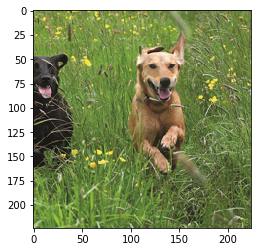

In [12]:
img = read_preprocess_image('./test.jpg')
plt.imshow(img)

a couple of dogs that are in the grass


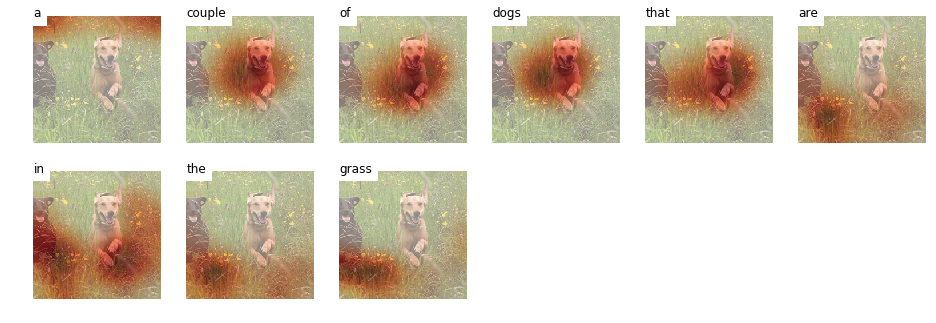

In [13]:
word2idx = read_json('./WORD2IDX_COCO.json')
idx2word = {idx: word for word, idx in word2idx.items()}

decoded_caption = [idx2word[i.item()] for i in caption]
caption_alphas = [tnsr.detach().numpy() for tnsr in alphas]
print(' '.join(decoded_caption))

img = read_preprocess_image('./test.jpg')
visualize_attention(img, decoded_caption, caption_alphas)

### Visualization Scratch

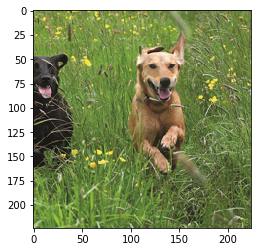

In [14]:
word2idx = read_json('./WORD2IDX_COCO.json')
idx2word = {idx: word for word, idx in word2idx.items()}

img = read_preprocess_image('./test.jpg')
plt.imshow(img)

a couple of dogs that are in the grass


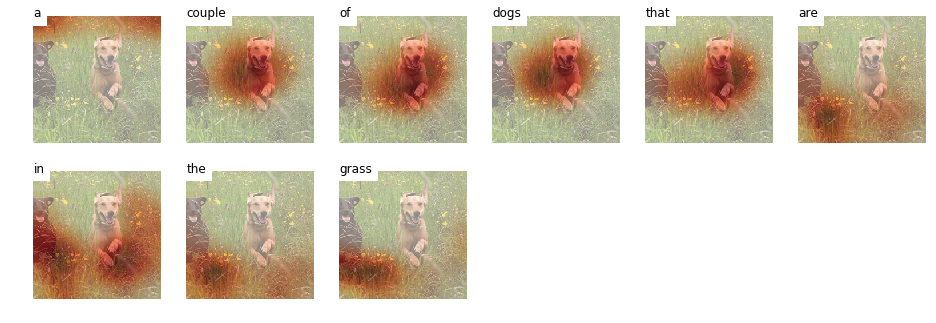

In [15]:
decoded_caption = [idx2word[i.item()] for i in caption]
caption_alphas = [tnsr.detach().numpy() for tnsr in alphas]
print(' '.join(decoded_caption))

img = read_preprocess_image('./test.jpg')
visualize_attention(img, decoded_caption, caption_alphas)

a couple of dogs that are in the grass


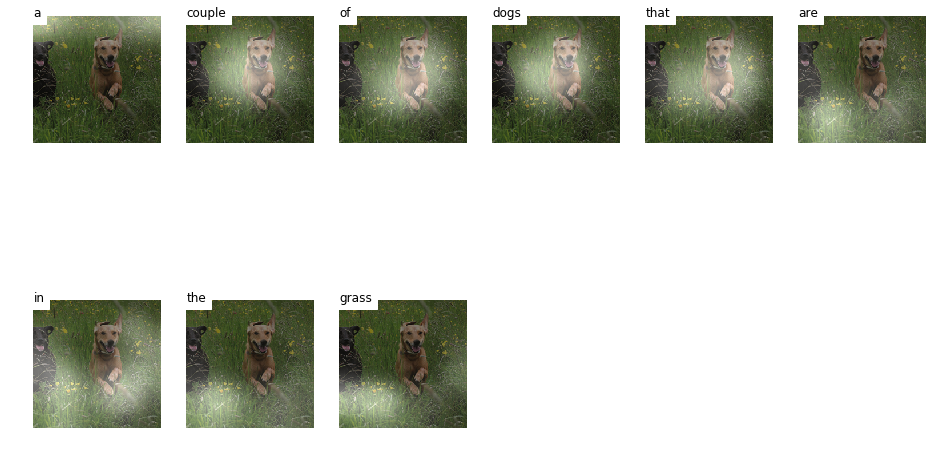

In [16]:
decoded_caption = [idx2word[i.item()] for i in caption]
caption_alphas = [tnsr.detach().numpy() for tnsr in alphas]
print(' '.join(decoded_caption))

ncols = 6
nrows = int(np.ceil(len(caption) / float(ncols)))

plt.figure(figsize=(16, 10))
for t in range(len(caption)):
    plt.subplot(nrows, ncols, t+1)
    plt.text(x=0, y=1, s=decoded_caption[t], backgroundcolor='white', fontsize=12)
    plt.imshow(img)
    alpha_t = caption_alphas[t].reshape(14, 14)
    alpha_img = skimage.transform.pyramid_expand(alpha_t, upscale=16, sigma=20, multichannel=False)
    plt.imshow(alpha_img, alpha=0.5)
    plt.set_cmap(cm.Greys_r)
    plt.axis('off')
    
plt.subplots_adjust(wspace=0.2, hspace=0.1)
plt.show()